## OUTLIER DETECTION DAY 3/OUTLIER DETECTION PART 5 EXERCISE ANSWERS ##
#### Exercise 1 ####
#### Task 1
##### Import the required packages
##### Set the `main_dir`, `data_dir`, and `plot_dir` variables
##### Print out each directory path to confirm
#### Result:


In [1]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA        # modern statsmodels API
home_dir = Path('.').resolve()
main_dir = home_dir.parent
data_dir = main_dir / 'data'
plot_dir = main_dir / 'plots'
print('main_dir =', main_dir)
print('data_dir =', data_dir)
print('plot_dir =', plot_dir)


main_dir = /Users/swaroopnc/Downloads/SkillAnamoly2025
data_dir = /Users/swaroopnc/Downloads/SkillAnamoly2025/data
plot_dir = /Users/swaroopnc/Downloads/SkillAnamoly2025/plots


#### Task 2
##### Load **PJM_Load_hourly.csv** into `load`
##### Convert `Datetime` to pandas `datetime` dtype and sort
##### Keep observations after **2001‑01‑01 00:00:00**
##### Aggregate to daily mean load (MW) as `daily`
#### Result:


In [2]:
load = pd.read_csv(data_dir / 'PJM_Load_hourly.csv')
load['Datetime'] = pd.to_datetime(load['Datetime'])
load = load.sort_values('Datetime')
load = load[load['Datetime'] > '2001-01-01 00:00:00']
load['Date'] = load['Datetime'].dt.date
daily = load.groupby('Date')['PJM_Load_MW'].mean()
print(load.shape)
print(daily.head())


(8758, 3)
Date
2001-01-01    30787.913043
2001-01-02    34796.458333
2001-01-03    35887.791667
2001-01-04    35187.666667
2001-01-05    35674.333333
Name: PJM_Load_MW, dtype: float64


#### Task 3
##### Decompose `daily` into trend, seasonal, and residual components
##### Plot each component separately
##### Identify which component shows the repeating yearly pattern
#### Result:


In [3]:
res = seasonal_decompose(daily.asfreq('D'))
res.trend.plot(title='Trend');      plt.show()
res.seasonal.plot(title='Seasonal'); plt.show()
res.resid.plot(title='Residual');   plt.show()


#### Task 4
##### Perform the Augmented Dickey‑Fuller test on `daily`
##### Print the ADF statistic and p‑value
##### State whether the series is stationary at α = 0.05
#### Result:


In [4]:
adf_stat, p_val, *_ = adfuller(daily)
print(f'ADF statistic = {adf_stat:.3f} | p‑value = {p_val:.4f}')
# p‑value > 0.05  ⇒ fail to reject H₀  ⇒ series is non‑stationary


ADF statistic = -2.156 | p‑value = 0.2225


#### Task 5
##### Fit an ARIMA(5,1,0) model to `daily`
##### Generate in‑sample forecasts (`typ="levels"`)
##### Plot actual vs. forecast on the same axes
#### Result:


/Users/swaroopnc/miniforge3/envs/skill_anamoly_2025/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/swaroopnc/miniforge3/envs/skill_anamoly_2025/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/swaroopnc/miniforge3/envs/skill_anamoly_2025/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


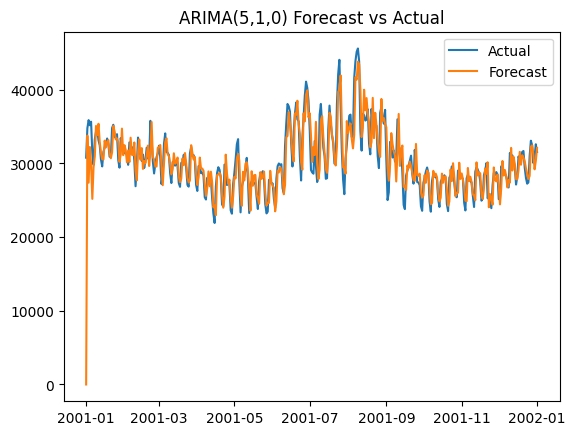

In [5]:
model = ARIMA(daily, order=(5,1,0))
fit   = model.fit()
forecast = fit.predict(typ='levels')
plt.plot(daily,    label='Actual')
plt.plot(forecast, label='Forecast')
plt.title('ARIMA(5,1,0) Forecast vs Actual')
plt.legend(); plt.show()


#### Task 6
##### Compute absolute residuals between actual and forecast
##### Calculate static threshold = mean + 3·std of residuals
##### Flag `static_anomaly` where residual ≥ threshold
#### Result:


In [6]:
results = pd.DataFrame({'actual': daily, 'predicted': forecast})
results['error'] = (results.actual - results.predicted).abs()
μ, σ = results.error.mean(), results.error.std()
results['static_threshold'] = μ + 3*σ
results['static_anomaly']   = results.error >= results.static_threshold


#### Task 7
##### Count and print number of `static_anomaly` points
##### Display their dates and values
##### Plot `daily` and mark static anomalies in red
#### Result:


Static anomalies: 2
                  actual     predicted         error  static_threshold  \
2001-01-01  30787.913043      0.000000  30787.913043       7838.881113   
2001-01-03  35887.791667  27400.064907   8487.726759       7838.881113   

            static_anomaly  
2001-01-01            True  
2001-01-03            True  


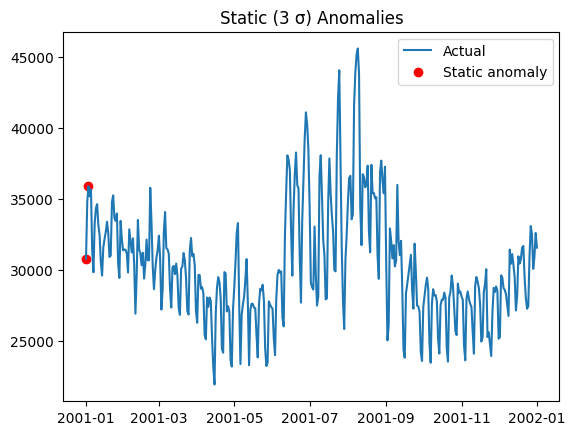

In [7]:
print('Static anomalies:', results.static_anomaly.sum())
print(results[results.static_anomaly])
plt.plot(results.actual, label='Actual')
plt.scatter(results.index[results.static_anomaly],
            results.actual[results.static_anomaly],
            color='red', label='Static anomaly')
plt.title('Static (3 σ) Anomalies'); plt.legend(); plt.show()


#### Task 8
##### Use a 7‑day rolling window to compute mean & std of residuals
##### Dynamic threshold = rolling_mean + 2·rolling_std
##### Flag `dynamic_anomaly` where residual ≥ dynamic threshold
##### Count and plot dynamic anomalies in orange
#### Result:


Dynamic anomalies: 15


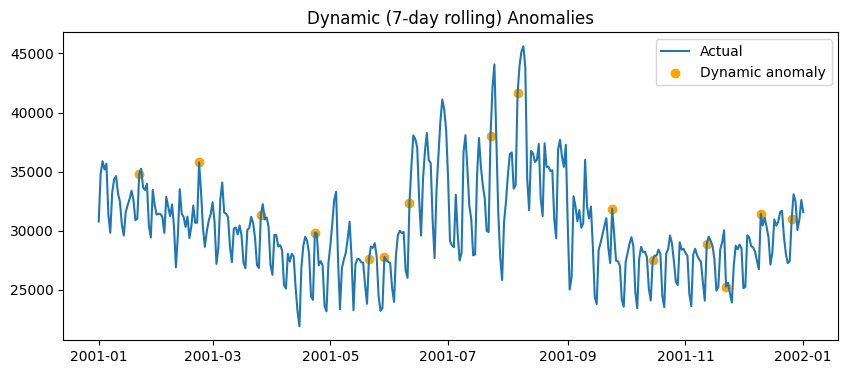

In [8]:
window = 7
results['roll_mean']     = results.error.rolling(window, min_periods=1).mean()
results['roll_std']      = results.error.rolling(window, min_periods=1).std()
results['dynamic_threshold'] = results.roll_mean + 2*results.roll_std
results['dynamic_anomaly']   = results.error >= results.dynamic_threshold
print('Dynamic anomalies:', results.dynamic_anomaly.sum())
plt.figure(figsize=(10,4))
plt.plot(results.actual, label='Actual')
plt.scatter(results.index[results.dynamic_anomaly],
            results.actual[results.dynamic_anomaly],
            color='orange', label='Dynamic anomaly')
plt.title('Dynamic (7‑day rolling) Anomalies')
plt.legend(); plt.show()
